In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from sklearn.manifold import TSNE
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import mpld3
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
import torch
%matplotlib inline

In [9]:
data = np.load(r'dataset/earbud/data_20_120.npy')
print(data.shape)
labels = np.load(r'dataset/earbud/label_20_120.npy')
print(labels.shape)
label = labels[:,0,0]
print(label.shape)

(615, 120, 6)
(615, 120, 2)
(615,)


In [12]:
#print unique lables count

unique, counts = np.unique(label, return_counts=True)
print(unique)
print(counts)

[ 1  2  3  4  5  6  7  8  9 10 11]
[48 50 48 52 61 61 48 62 68 50 67]


In [4]:
def compute_energy(seqs):
    """
    Compute energy of the input sequence.
    Args:
        seqs: Tensor (batch_size, seq_len, feature_size) representing IMU sequences.
    
    Returns:
        energy: A list or tensor representing the energy of the sequence.
    """
    energy = torch.sqrt((seqs ** 2).sum(dim=-1))  # Simple norm-based energy calculation
    return energy


def detect_nucleus(energy, window=20, nucleus_thres=0.4):
    """
    Detects the nucleus of gestures based on changes in signal energy.

    Parameters:
    - energy: Tensor (batch_size, sequence_length) containing energy values
    - window: int, window size for detecting changes
    - nucleus_thres: float, threshold for significant energy change
    
    Returns:
    - filtered_change_pts: list of lists, each containing start and end points of the nucleus for each sequence
    """
    batch_nucleus_points = []

    # Loop over each sequence in the batch
    for sequence_energy in energy:
        change_pts = []

        # Convert each sequence to a list of scalars (optional if already 1D)
        sequence_energy = sequence_energy.cpu().numpy() if sequence_energy.is_cuda else sequence_energy.numpy()

        # Sliding window to detect energy changes
        for i in range(len(sequence_energy) - 15):
            if abs(sequence_energy[i + 15] - sequence_energy[i]) > nucleus_thres:
                change_pts.append(i)

        # If no change points are detected, use default nucleus points
        if not change_pts:
            filtered_change_pts = [0, min(len(sequence_energy), window)]
        else:
            # Adjust detected change points
            change_pts = list(map(lambda x: x + window, change_pts))
            
            # Filter close change points
            filtered_change_pts = [change_pts[0]]
            for i in range(1, len(change_pts)):
                if change_pts[i] - filtered_change_pts[-1] >= window:
                    filtered_change_pts.append(change_pts[i])

            filtered_change_pts = filtered_change_pts[:2]

            # Adjust if only one change point detected
            if len(filtered_change_pts) == 1:
                filtered_change_pts.append(change_pts[-1] + 10)

        batch_nucleus_points.append(filtered_change_pts)

    return batch_nucleus_points

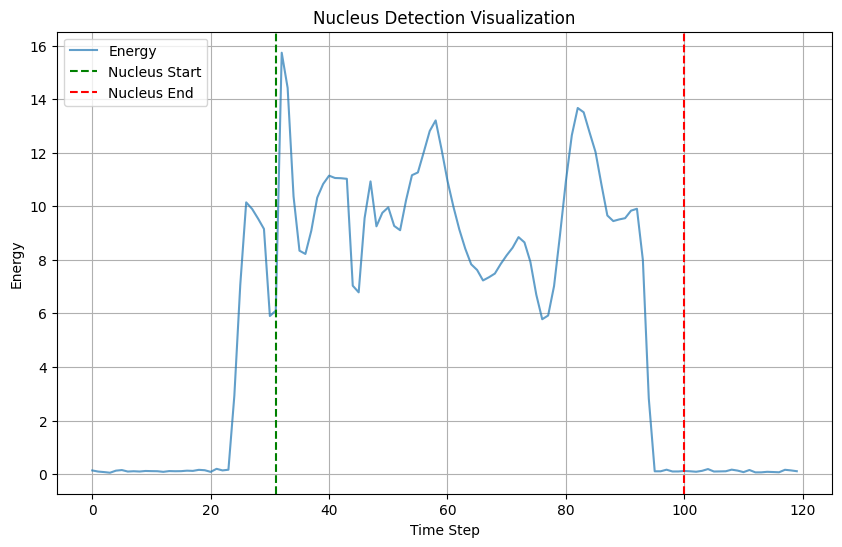

In [6]:
# Load example data
data_file = r'dataset/augmented_data/augmented_combined_data_20_120.npy'  # Replace with the actual .npy file path
data = np.load(data_file)  # Load your .npy file

# Convert data to a PyTorch tensor
data_tensor = torch.tensor(data)

# Compute energy
energy = compute_energy(data_tensor)

# Detect nucleus
nucleus_points = detect_nucleus(energy, window=20, nucleus_thres=8)

# Visualize data with nucleus points
sample_size = 1  # Define the sample size
sample_index = np.random.choice(data.shape[0], sample_size, replace=False)[0]


sequence_energy = energy[sample_index].numpy()
nucleus_start, nucleus_end = nucleus_points[sample_index]

plt.figure(figsize=(10, 6))
plt.plot(sequence_energy, label='Energy', alpha=0.7)
plt.axvline(x=nucleus_start, color='green', linestyle='--', label='Nucleus Start')
plt.axvline(x=nucleus_end, color='red', linestyle='--', label='Nucleus End')
plt.title('Nucleus Detection Visualization')
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

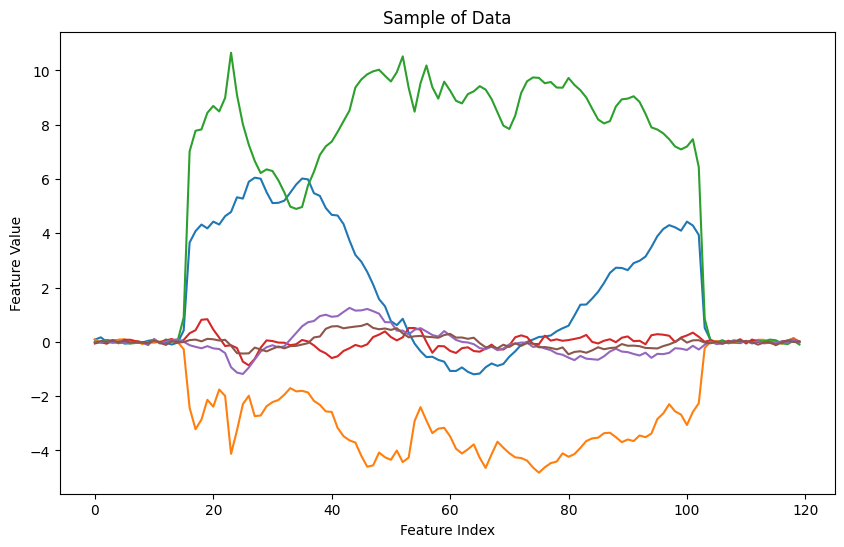

In [7]:
# Plot a sample of the data
sample_size = 1  # Define the sample size
sample_indices = np.random.choice(data.shape[0], sample_size, replace=False)
sample_data = data[sample_indices]

plt.figure(figsize=(10, 6))
for i in range(sample_size):
    plt.plot(sample_data[i], label=f'Sample {i+1}')
plt.title('Sample of Data')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

In [5]:
unique_labels = np.unique(label)
print(unique_labels)
label_dict = {}

for i in unique_labels:
    label_dict[i] = []

for i in range(len(label)):
    label_dict[label[i]].append(i)
print(label_dict)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
{1: [31, 41, 50, 51, 60, 61, 71, 72, 76, 79, 172, 182, 191, 192, 201, 202, 212, 213, 218, 222, 322, 480, 490, 500, 501, 506, 510, 743, 754, 763, 764, 773, 774, 784, 785, 790, 794, 895, 905, 914, 915, 923, 924, 935, 936, 941, 945, 1045, 1055, 1064, 1065, 1074, 1075, 1086, 1087, 1092, 1096, 1192, 1202, 1209, 1216, 1226, 1316, 1326, 1335, 1336, 1345, 1346, 1356, 1357, 1362, 1366], 2: [3, 11, 12, 17, 18, 21, 26, 29, 104, 109, 144, 152, 153, 158, 159, 162, 167, 170, 253, 258, 294, 302, 303, 308, 309, 312, 317, 320, 397, 433, 441, 442, 447, 448, 451, 456, 459, 538, 543, 579, 587, 588, 593, 594, 597, 602, 605, 674, 679, 715, 723, 724, 729, 730, 733, 738, 741, 825, 830, 867, 875, 876, 881, 882, 885, 890, 893, 976, 981, 1017, 1025, 1026, 1031, 1032, 1035, 1040, 1043, 1126, 1131, 1173, 1174, 1179, 1180, 1183, 1187, 1190, 1251, 1256, 1288, 1296, 1297, 1302, 1303, 1306, 1311, 1314, 1397, 1404], 3: [32, 40, 49, 52, 59, 63, 68, 81, 87, 102, 173, 181, 19

In [6]:
embed = np.load('embed/embed_limu_v1_blind_fine_tune_20_120.npy')
print(embed.shape)
# drop second dimension

#embed = embed[:,30,:]
embed = embed.mean(axis=1) #avg over 120 frames
pca = PCA(n_components=3)
pca.fit(embed)
embed_pca = pca.transform(embed)
print(embed_pca.shape)


(1439, 120, 72)
(1439, 3)


In [7]:
label_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [8]:
tsne = TSNE(n_components=3)
# Fit and transform the data
embed_tsne = tsne.fit_transform(embed)
embed_tsne

array([[ -9.73261   ,  13.886773  ,   1.0967469 ],
       [  9.047404  ,   3.6479466 ,   3.5576782 ],
       [  8.213609  ,   1.4112246 ,   7.74028   ],
       ...,
       [ -2.1426625 ,  -1.277854  ,  -4.320551  ],
       [  4.9748344 ,  -1.5988475 ,  -1.9554223 ],
       [-10.112862  ,   8.668748  ,   0.32458314]], dtype=float32)

In [13]:

fig = plt.figure()
ax = fig.add_subplot(111)
for i in label_dict[1]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='r', marker='o')
for i in label_dict[2]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='b', marker='o')
for i in label_dict[3]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='g', marker='o')
for i in label_dict[4]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='y', marker='o')
for i in label_dict[5]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='c', marker='o')
for i in label_dict[6]:
    ax.scatter(embed_tsne[i,0], embed_tsne[i,1], c='m', marker='o')

plt.show()

2024-10-17 10:49:38.287 python[9035:4237902] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-17 10:49:38.287 python[9035:4237902] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [9]:
%matplotlib qt
fig = go.Figure()

# Add points for label 1
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[1], 0],
    y=embed_tsne[label_dict[1], 1],
    z=embed_tsne[label_dict[1], 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Label 1'
))

# Add points for label 2
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[2], 0],
    y=embed_tsne[label_dict[2], 1],
    z=embed_tsne[label_dict[2], 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Label 2'
))
# Add points for label 3
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[3], 0],
    y=embed_tsne[label_dict[3], 1],
    z=embed_tsne[label_dict[3], 2],
    mode='markers',
    marker=dict(size=5, color='green'),
    name='Label 3'
))

# Add points for label 4
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[4], 0],
    y=embed_tsne[label_dict[4], 1],
    z=embed_tsne[label_dict[4], 2],
    mode='markers',
    marker=dict(size=5, color='yellow'),
    name='Label 4'
))

# Add points for label 5
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[5], 0],
    y=embed_tsne[label_dict[5], 1],
    z=embed_tsne[label_dict[5], 2],
    mode='markers',
    marker=dict(size=5, color='orange'),
    name='Label 4'
))

# Add points for label 6
fig.add_trace(go.Scatter3d(
    x=embed_tsne[label_dict[6], 0],
    y=embed_tsne[label_dict[6], 1],
    z=embed_tsne[label_dict[6], 2],
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Label 4'
))

# Set plot title and axis labels
fig.update_layout(
    title='3D Scatter Plot of TSNE Data',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the interactive plot
fig.show()


In [79]:
import numpy as np


distance_matrix = np.zeros((15, 15))

# Loop through all pairs of labels (i, j)
for i in range(1, 16):
    for j in range(1, 16):
        # Get the indices for the current labels
        indices_i = label_dict[i]
        indices_j = label_dict[j]

        # Extract the points corresponding to the indices from embed_tsne
        points_i = embed[indices_i]
        points_j = embed[indices_j]

        # Calculate the pairwise distances between points_i and points_j
        pairwise_distances = cdist(points_i, points_j)

        # Take the mean of all pairwise distances and store it in the matrix
        distance_matrix[i-1, j-1] = np.mean(pairwise_distances)

# Now `distance_matrix` is a 15x15 matrix where each element (i, j)
# is the average distance between the points in label i and label j
print(distance_matrix)


[[ 5.97076542  6.79543289  6.43843614  6.74614725  6.54915661  7.57912258
   7.88706069  8.40019488  7.83660698  8.69736434  7.45017263  6.76071714
   7.35375923  9.99385365  7.92445457]
 [ 6.79543289  5.85962318  6.58724181  6.08824476  6.63296095  7.32938908
   7.87608027  8.04377579  7.59826695  8.29213058  7.0245918   6.61870274
   7.08944604  9.61441712  7.91031479]
 [ 6.43843614  6.58724181  5.83827357  6.59020253  6.51881028  6.75651135
   8.05061025  7.9727426   7.49372664  8.65717662  6.65257012  6.60817438
   6.61285936  9.2107917   7.870979  ]
 [ 6.74614725  6.08824476  6.59020253  5.90588083  6.63072356  7.42019472
   7.88727903  8.15765183  7.60355325  8.25901642  7.06584349  6.5938113
   7.22681206  9.77286778  7.9718515 ]
 [ 6.54915661  6.63296095  6.51881028  6.63072356  6.04714971  7.46510828
   8.1388874   8.33130448  7.79147268  8.51243619  7.2527157   6.87582644
   7.17220031  9.91130424  8.08933541]
 [ 7.57912258  7.32938908  6.75651135  7.42019472  7.46510828  6.1

In [80]:
distance_matrix_normalized = distance_matrix / distance_matrix.sum(axis=1, keepdims=True)

epsilon = 1e-10
distance_matrix_reciprocal = 1 / (distance_matrix_normalized + epsilon)



plt.figure(figsize=(8, 6))
plt.imshow(distance_matrix_normalized, cmap='Greys', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Distance Matrix Heatmap')
plt.xlabel('Labels')
plt.ylabel('Labels')

# Show the plot
plt.show()